# **TikTok Claims Classification Project: Hypothesis Test**

<img src="../Images/bubble_logo.png" alt="Logo" style="float:left; width:120px; height:120px;">

## **Introduction**

In this stage of the TikTok Claims Classification project, we aim to determine whether there is a statistically significant difference in video view counts between verified and unverified accounts. Using descriptive statistics and hypothesis testing, we will analyze the engagement patterns of these two groups. The results will help provide deeper insights into user behavior, which can further inform the development of a machine learning model to classify TikTok interactions as either claims or opinions.

This Jupyter Notebook serves as a technical summary for internal stakeholders (the data team), documenting the full analysis process, including data exploration, cleaning, statistical testing, and the interpretation of results. It is intended to provide transparency and allow for validation of the methods and findings before sharing insights with external stakeholders.

## **Dataset Exploration**

* Import packages and upload dataset
* Initial Inspection
* Descriptive Statistics - Determine the most insightful variable

In [5]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import package for statistical analysis
from scipy import stats

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
# Load dataset into dataframe
df = pd.read_csv(r'C:\Users\danet\Documents\tiktok_dataset.csv')

In [9]:
df.head(3)

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0


In [11]:
# Descriptive Statistics
df.describe()

,#,video_id,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
count,19382.000000,1.938200e+04,19382.000000,19084.000000,19084.000000,19084.000000,19084.000000,19084.000000
mean,9691.500000,5.627454e+09,32.421732,254708.558688,84304.636030,16735.248323,1049.429627,349.312146
std,5595.245794,2.536440e+09,16.229967,322893.280814,133420.546814,32036.174350,2004.299894,799.638865
min,1.000000,1.234959e+09,5.000000,20.000000,0.000000,0.000000,0.000000,0.000000
25%,4846.250000,3.430417e+09,18.000000,4942.500000,810.750000,115.000000,7.000000,1.000000
50%,9691.500000,5.618664e+09,32.000000,9954.500000,3403.500000,717.000000,46.000000,9.000000
75%,14536.750000,7.843960e+09,47.000000,504327.000000,125020.000000,18222.000000,1156.250000,292.000000
max,19382.000000,9.999873e+09,60.000000,999817.000000,657830.000000,256130.000000,14994.000000,9599.000000


***Focus on Video View Counts***

After reviewing the descriptive statistics, it's clear that video view count is a key metric for analyzing user engagement. With its significant variability and wide range, this variable provides valuable insight into how verified and unverified accounts perform on TikTok. As Rosie Mae Bradshaw suggested, focusing on video view counts will allow us to explore whether account verification leads to measurable differences in video reach and engagement.

## **Data Cleaning**

***Handling Missing Values:***
 As established in the previous EDA, there are missing values across the same 7 columns in 298 rows. Since dropping these rows only reduces the dataset by 1.54%, which is a minimal loss, I will proceed to drop them now to maintain the integrity of the analysis.

In [20]:
# Confirm Missing Values
print(f"Total Elements: {df.size:,}")
print(f"Total Rows: {df.shape[0]:,}")
print(f"Total Columns: {df.shape[1]}")
df.isnull().sum()

Total Elements: 232,584
Total Rows: 19,382
Total Columns: 12


#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [17]:
# Drop rows with missing values
df_cleaned = df.dropna()

In [21]:
# Confirm entries has dropped from 19,382 down to 19,084
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19084 entries, 0 to 19083
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19084 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19084 non-null  int64  
 3   video_duration_sec        19084 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19084 non-null  object 
 6   author_ban_status         19084 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.9+ MB


<br>

## **Exploring Mean Video View Count by Verification Status**

In this section, I aim to compare the mean video view counts between verified and unverified accounts. By calculating and displaying the total number of accounts, total video views, and average video views for each group, I can gain initial insights into how account verification affects engagement. Additionally, I will create visualizations to provide a clearer understanding of the differences between the two groups before moving into the hypothesis test.

In [25]:
# Function to format large numbers
def format_large_numbers(num):
    if num >= 1e9:
        return f'{num/1e9:.2f}B'
    elif num >= 1e6:
        return f'{num/1e6:.2f}M'
    else:
        return f'{num}'

# Group by 'verified_status' and calculate the total video view counts
verified_view_counts = df_cleaned.groupby('verified_status')['video_view_count'].sum()

# Count the total number of verified and not verified accounts
verified_account_counts = df_cleaned['verified_status'].value_counts()

# Calculate the mean video view count per verified status
mean_view_counts = df_cleaned.groupby('verified_status')['video_view_count'].mean()

# Create a DataFrame with both total counts and view counts
summary_df = pd.DataFrame({
    'Total Accounts': verified_account_counts,
    'Total Video Views': verified_view_counts,
    'Mean Video Views': mean_view_counts
})

# Apply the large number formatting to the 'Total Video Views' column
summary_df['Total Video Views'] = summary_df['Total Video Views'].apply(format_large_numbers)

# Display the updated DataFrame
summary_df

,Total Accounts,Total Video Views,Mean Video Views
verified_status,,,
not verified,17884,4.75B,265663.785339
verified,1200,109.73M,91439.164167


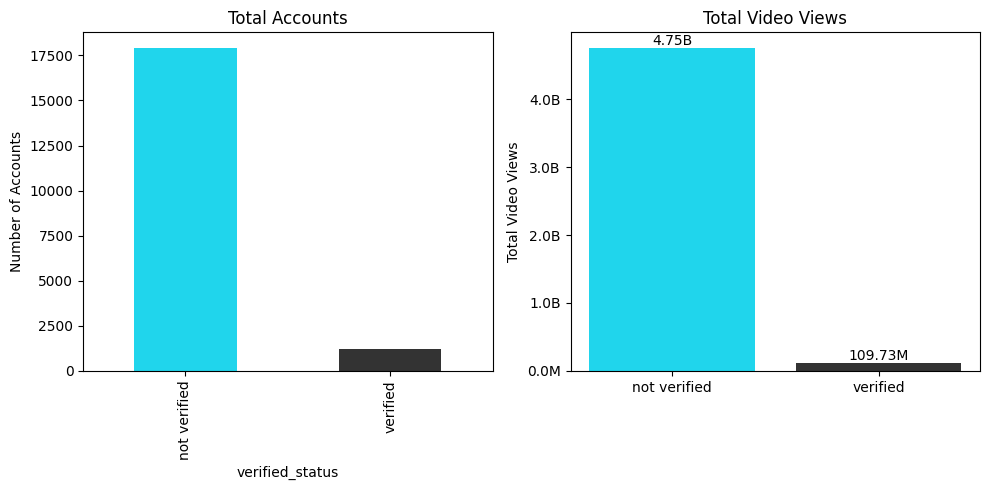

In [27]:
import matplotlib.ticker as mticker

# Configure sizes for both subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Bar chart for Total Accounts
summary_df['Total Accounts'].plot(kind='bar', color=['#20D5EC', '#333333'], ax=axes[0])
axes[0].set_title('Total Accounts')
axes[0].set_ylabel('Number of Accounts')

# Bar chart for Total Video Views
bars2 = axes[1].bar(summary_df.index, verified_view_counts, color=['#20D5EC', '#333333'])
axes[1].set_title('Total Video Views')
axes[1].set_ylabel('Total Video Views')

# Annotate Total Video Views bars with formatted values
for bar, value in zip(bars2, verified_view_counts):
    label = f'{value/1e9:.2f}B' if value >= 1e9 else f'{value/1e6:.2f}M'
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), label, ha='center', va='bottom')

# Format y-axis labels in billions (B) or millions (M) for the second plot
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.1f}M'))

plt.tight_layout()
plt.show()

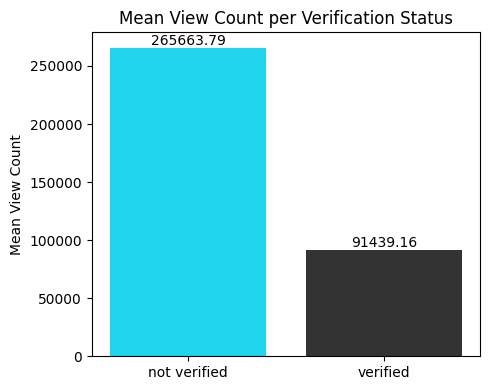

In [32]:
# Configure size
plt.figure(figsize=(5, 4))

# Bar chart for Mean View Count
bars = plt.bar(summary_df.index, mean_view_counts, color=['#20D5EC', '#333333'])
plt.title('Mean View Count per Verification Status')
plt.ylabel('Mean View Count')

# Annotate the bars with their values
for bar, value in zip(bars, mean_view_counts):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{value:.2f}', ha='center', va='bottom')

plt.show()

***Insights***

* The analysis shows that unverified accounts significantly outperform verified accounts in terms of video views. With 17,884 unverified accounts generating a total of 4.75 billion views (an average of 265,663 views per account), unverified accounts see nearly three times the average views compared to verified accounts.
* In contrast, 1,200 verified accounts generated a total of 109.73 million views, with an average of 91,439 views per account. This substantial difference highlights a noteworthy gap in engagement between the two groups.

## **Hypothesis Testing: Video View Counts by Verification Status**

In this section, I will conduct a hypothesis test to determine whether there is a statistically significant difference in the mean video view counts between verified and unverified TikTok accounts. This test will help confirm whether the observed differences in average video views between the two groups, as seen in the previous analysis, are due to random chance or if they reflect a real distinction in engagement. The results will provide valuable insights into the relationship between account verification and user engagement on the platform.

***Null Hypothesis (H₀):*** There is no statistically significant difference in the video view counts between verified and unverified accounts.

***Alternative Hypothesis (H₁):*** There is a statistically significant difference in the video view counts between verified and unverified accounts.

In [33]:
# Significance Level
significance_level = 0.05

# Samples
not_verified = df_cleaned[df_cleaned["verified_status"] == "not verified"]["video_view_count"]
verified = df_cleaned[df_cleaned["verified_status"] == "verified"]["video_view_count"]

# Implement a t-test using the two samples
ttest, p_value = stats.ttest_ind(a=not_verified, b=verified, equal_var=False)
print(f"TTEST: {ttest}")
print(f"P-Value: {p_value} or ")

TTEST: 25.499441780633777
P-Value: 2.6088823687177823e-120 or 


***Insight***

With a p-value of 2.6088e-120, far below the 5% significance threshold, we reject the null hypothesis. The results are highly statistically significant, indicating that the difference in video view counts between verified and unverified accounts is not due to random chance.

## **Summary of Results**

The hypothesis test confirmed a statistically significant difference in video view counts between verified and unverified accounts (p-value: 2.6088e-120), suggesting that factors beyond verification status likely influence engagement. This raises the need to explore other elements like content type or posting frequency.

Unverified accounts, on average, receive 190.54% more views than verified accounts, suggesting they may employ different content strategies that drive higher engagement.

Next, we will develop a regression model incorporating verification status to further analyze its impact on user behavior and its relevance to classifying posts as claims or opinions. This model will help manage the imbalance between verified and unverified accounts and provide deeper insights into the factors driving engagement.